# FFT model training

In this notebook we will train a model based of fast Fourier transform for detection of atrial fibrillation.

* [Init dataset](#Init-dataset)
* [Train pipeline](#Train-pipeline)
* [Show loss and metric on train](#Show-loss-and-metric-on-train)
* [Make predictions](#Make-predictions)

## Init dataset

For model training we will use the PhysioNet's short single lead ECG recording [database](https://physionet.org/challenge/2017/). To follow the tutorial download the PhysioNet's database.

In [1]:
import sys, os
sys.path.append(os.path.join("..", "..", ".."))

from cardio import EcgDataset
eds = EcgDataset(path="/notebooks/data/ECG/training2017/*.hea", no_ext=True, sort=True)
eds.split(0.8)

## Train pipeline

To train the model we construct a ```train_pipeline```. Within the pipeline we initialize the ```FFTModel``` model with given model_config, initialize variable to store loss, load and preprocesse signals, declare which components of the batch are ```x``` and ```y``` for the model and train the model.

In [2]:
import numpy as np
import cardio.batchflow as bf
from cardio.batchflow import F, V, B
from cardio.models.fft_model import FFTModel

model_config = {
    "input_shape": F(lambda batch: batch.signal[0].shape),
    "loss": "binary_crossentropy",
    "optimizer": "adam"
}

def make_data(batch, **kwagrs):
    return {'x': np.array(list(batch.signal)), 'y': batch.target}
    
train_pipeline = (bf.Pipeline()
                  .init_model("dynamic", FFTModel, name="fft_model", config=model_config)
                  .init_variable("loss_history", init_on_each_run=list)
                  .load(fmt="wfdb", components=["signal", "meta"])
                  .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv",
                        fmt="csv", components="target")
                  .drop_labels(["~"])
                  .rename_labels({"N": "NO", "O": "NO"})
                  .random_resample_signals("normal", loc=300, scale=10)
                  .drop_short_signals(4000)
                  .split_signals(3000, 3000)
                  .binarize_labels()
                  .apply_transform(np.transpose, axes=[0, 2, 1], src='signal', dst='signal')
                  .unstack_signals()
                  .train_model('fft_model', make_data=make_data,
                               save_to=V("loss_history"), mode="a"))

Using TensorFlow backend.


Run ```train_pipeline```:

In [3]:
%env CUDA_VISIBLE_DEVICES=1

fft_trained = (eds.train >> train_pipeline).run(batch_size=300, shuffle=True,
                                                drop_last=True, n_epochs=250, prefetch=0)

## Show loss and metric on train

Now ```fft_trained``` contains trained model and loss history. Method ```get_variable``` allows to get ```loss_history``` and we can plot it:

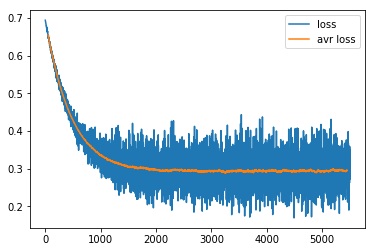

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

loss = pd.DataFrame(fft_trained.get_variable("loss_history"), columns=["loss"])
loss["avr loss"] = pd.DataFrame(loss).rolling(center=True, window=100).mean()
loss.plot()
plt.show()

## Make predictions

For predictions we create ```predict_pipeline```. It differs from ```train_pipeline``` in several things. We import trained model instead of initializing a new one and apply ```predict_model``` instead of ```train_model``` action. Another difference is that we aggregate predictions on signal segments into the final prediction for the whole signal. Function ```make_pivot``` is responsible for it.

In [5]:
def make_pivot(pipeline, variable_name):
    cropes = np.array([x[0] for x in pipeline.get_variable("shapes")])
    pos = np.vstack([np.pad(np.cumsum(cropes)[:-1], pad_width=(1, 0), mode='constant'), cropes]).T
    labels = np.array(pipeline.get_variable(variable_name))    
    return np.array([labels[s: s + i].mean(axis=0) for s, i in pos])

predict_pipeline = (bf.Pipeline()
                    .import_model("fft_model", fft_trained)
                    .init_variable("true_labels", init_on_each_run=list)
                    .init_variable("pred_labels", init_on_each_run=list)
                    .init_variable("shapes", init_on_each_run=list)
                    .init_variable("pivot_true_labels", init_on_each_run=list)
                    .init_variable("pivot_pred_labels", init_on_each_run=list)
                    .load(fmt="wfdb", components=["signal", "meta"])
                    .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv",
                          fmt="csv", components="target")
                    .drop_labels(["~"])
                    .rename_labels({"N": "NO", "O": "NO"})
                    .drop_short_signals(4000)
                    .split_signals(3000, 3000)
                    .binarize_labels()
                    .apply_transform(np.transpose, axes=[0, 2, 1], src='signal', dst='signal')
                    .update_variable("shapes", F(lambda batch: [x.shape for x in batch.signal]), mode='w')
                    .unstack_signals()
                    .update_variable("true_labels", B('target'), mode='w')
                    .predict_model('fft_model', make_data=make_data, save_to=V("pred_labels"), mode="w")
                    .update_variable("pivot_true_labels", F(lambda batch: make_pivot(batch.pipeline,
                                                                                     'true_labels')), mode='e')
                    .update_variable("pivot_pred_labels", F(lambda batch: make_pivot(batch.pipeline,
                                                                                     'pred_labels')), mode='e'))

Run ```predict_pipeline``` on the test part of the dataset:

In [6]:
res_test = (eds.test >> predict_pipeline).run(batch_size=300, shuffle=False, drop_last=False,
                                           n_epochs=1, prefetch=0)

Consider predicted values and true labels which are stored in ```pivot_pred_labels``` and ```pivot_true_labels```. We get them through ```get_variable``` method and caclulate several classification metrics:

In [7]:
from sklearn.metrics import f1_score

print(f1_score(np.array(res_test.get_variable("pivot_true_labels"))[:, 0],
               np.rint(res_test.get_variable("pivot_pred_labels"))[:, 0], average='macro'))

0.878696268304


In [8]:
from sklearn.metrics import classification_report

print(classification_report(np.array(res_test.get_variable("pivot_true_labels"))[:, 0],
                            np.rint(res_test.get_variable("pivot_pred_labels"))[:, 0]))

             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98      1443
        1.0       0.88      0.70      0.78       162

avg / total       0.96      0.96      0.96      1605

